# Tusya Detection. Object Recognition.

## Installing Libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
import time
import os

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog

import PIL
import cv2

sns.set_theme(palette='pastel')
plt.rcParams["axes.grid"] = False

## Loading the Dataset

In [2]:
def load_images_from_folder(path):
    images = []
    for img_name in os.listdir(path):
        img = np.array(PIL.Image.open(path+img_name))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, MIN_SIZE)
        images.append(img)
    return images

In [3]:
def load_image(path):
    return np.array(PIL.Image.open(path))

In [4]:
def get_hog(img, block_norm = 'L2-Hys', visualize=False):
    
    if visualize:
        img_features, visual = hog(img, pixels_per_cell = PIXELS_PER_CELL,
                                   cells_per_block = CELLS_PER_BLOCK,
                                   block_norm = block_norm,
                                   visualize = True)
        return img_features, visual

    else:
        img_features = hog(img, pixels_per_cell = PIXELS_PER_CELL,
                           cells_per_block = CELLS_PER_BLOCK,
                           block_norm = block_norm)
    
    return img_features

While I was taking the pictures, I noticed that Tusya's head can ideally be fitted in a square. 

In [5]:
path1 = 'PositiveTusyaHead/'
path2 = 'NegativeTusya/'
MIN_SIZE = (150,150)

PIXELS_PER_CELL = (15,15)
CELLS_PER_BLOCK = (3,3)

In [6]:
positive_tusya = load_images_from_folder(path1)
negative_tusya = load_images_from_folder(path2)
print('Positive dataset shape:', len(positive_tusya))
print('Negative dataset shape:', len(negative_tusya))

Positive dataset shape: 96
Negative dataset shape: 432


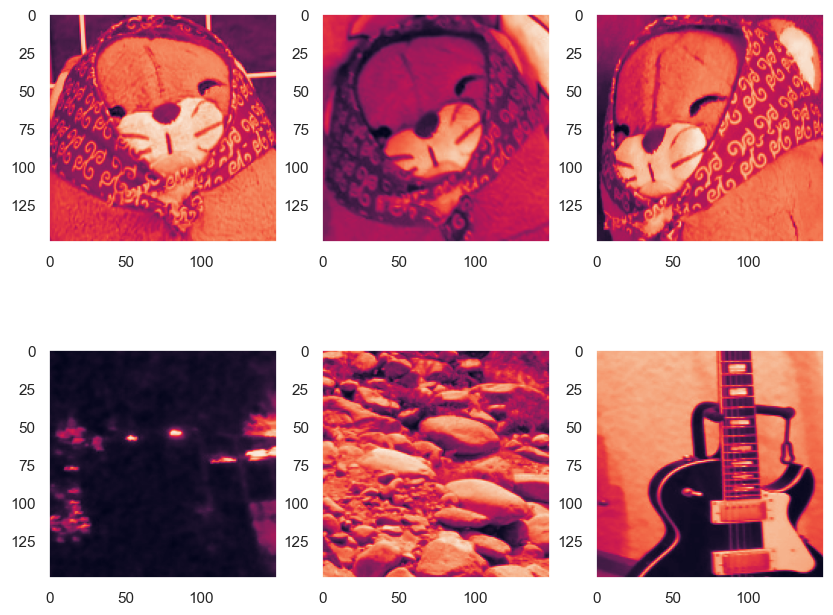

In [7]:
ncols = 3
fig, axs = plt.subplots(2,ncols, figsize=(10,8))
for i in range(3):
    axs[0, i].imshow(positive_tusya[random.choice(range(len(positive_tusya)))])
    axs[1, i].imshow(negative_tusya[random.choice(range(len(negative_tusya)))])

## Histogram of Oriented Gradients (HOG)

In [8]:
pos_features = np.array([get_hog(x) for x in positive_tusya])
neg_features = np.array([get_hog(x) for x in negative_tusya])
pos_labels = np.ones(pos_features.shape[0])
neg_labels = np.zeros(neg_features.shape[0])

X = np.concatenate([pos_features, neg_features])
y = np.concatenate([pos_labels, neg_labels])

print('Shape of Positives:', pos_features.shape)
print('Shape of Negatives:', neg_features.shape)
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of Positives: (96, 5184)
Shape of Negatives: (432, 5184)
Shape of X: (528, 5184)
Shape of y: (528,)


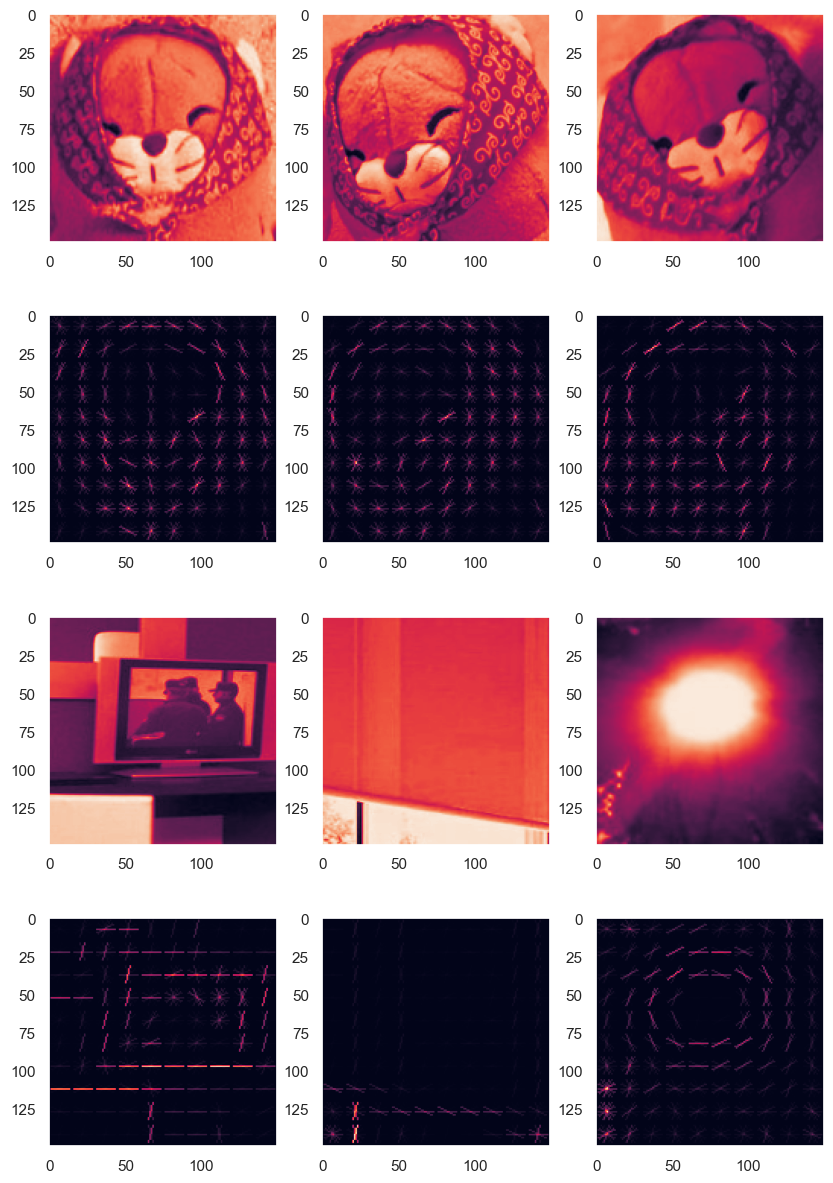

In [9]:
ncols = 3
fig, axs = plt.subplots(4, ncols, figsize=(10,15))
for j in range(ncols):
    sample_index = random.choice(range(len(positive_tusya)-1))
    _, visual = get_hog(positive_tusya[sample_index], visualize=True)
    axs[0, j].imshow(positive_tusya[sample_index])
    axs[1, j].imshow(visual)
for j in range(ncols):
    sample_index = random.choice(range(len(negative_tusya)-1))
    _, visual = get_hog(negative_tusya[sample_index], visualize=True)
    axs[2, j].imshow(negative_tusya[sample_index])
    axs[3, j].imshow(visual)
        
plt.show()

## Prior Model Testing

In [10]:
skf = StratifiedKFold(4, shuffle=True, random_state=582002)

train_index, test_index = next(skf.split(X,y))
X_train, y_train = X[train_index], y[train_index]
X_test, y_test = X[test_index], y[test_index]

print(X.shape)
print(X_train.shape)
print(X_test.shape)

(528, 5184)
(396, 5184)
(132, 5184)


              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       108
         1.0       1.00      0.83      0.91        24

    accuracy                           0.97       132
   macro avg       0.98      0.92      0.95       132
weighted avg       0.97      0.97      0.97       132



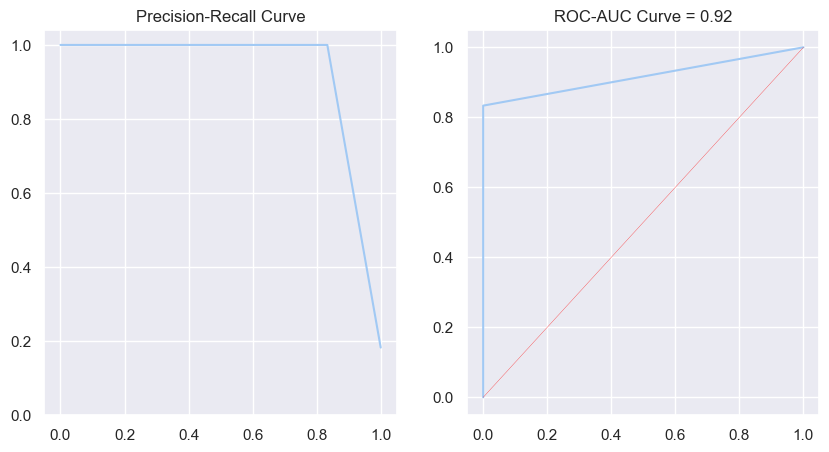

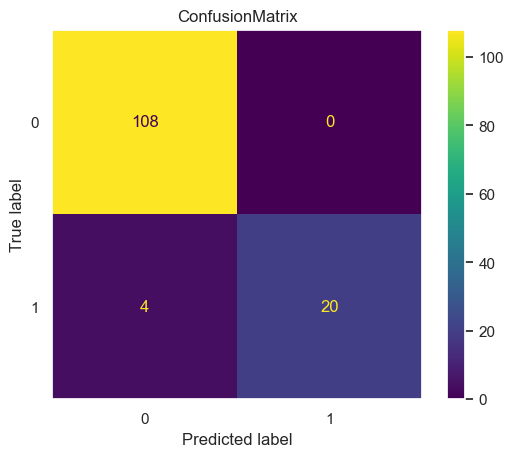

In [11]:
svc = SVC(kernel='rbf').fit(X_train, y_train)
preds = svc.predict(X_test)

cm = confusion_matrix(y_test, preds)
CM = ConfusionMatrixDisplay(cm)
fpr, tpr, thresholds = roc_curve(y_test, preds)
prec, rec, thresholds = precision_recall_curve(y_test, preds)

print(classification_report(y_test, preds))

plt.rcParams["axes.grid"] = True
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(rec, prec)
plt.yticks(np.arange(0,1.1, .2))
plt.title('Precision-Recall Curve')

plt.subplot(122)
plt.plot(fpr, tpr)
sns.lineplot(x=[0,1],y=[0,1], color='red', linewidth=0.2)
plt.title(f'ROC-AUC Curve = {round(roc_auc_score(y_test, preds), 2)}')

CM.plot()
plt.title('ConfusionMatrix')
plt.grid(False)
plt.show()

In [12]:
#false negative is TEST-PREDS == 1, false positive is TEST-PREDS == -1
#true positive or true negative will be TEST-PREDS == 0
false = y_test - preds != 0
false_index = test_index[false]
false_index

array([34, 51, 64, 66])

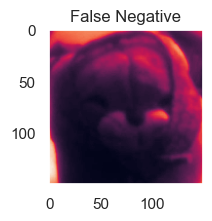

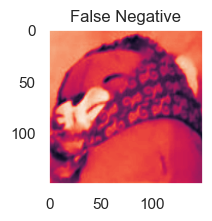

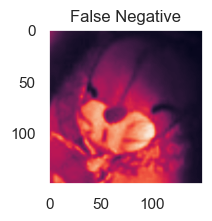

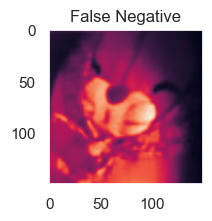

In [13]:
plt.rcParams['axes.grid'] = False
for i in false_index:
    plt.figure(figsize=(2,2))
    if i < len(positive_tusya) - 1:
        plt.imshow(positive_tusya[i])
        plt.title('False Negative')
        plt.show()
    else:
        plt.imshow(negative_tusya[i])
        plt.title('False Positive')
        plt.show()

In [14]:
svc = SVC(kernel='rbf').fit(X, y)

## Object Recognition Algorithm

* The window with the size `MIN_SIZE` slides over the picture creating HOG features. After each full scan, the window size increases. Increasing the window size allows us to recognize Tusya of any size.
* Due to the fact our window is increasing its own size after each image scanning we must to resize each window image to `MIN SIZE` so that our model can work.
* Our model gets HOG features and gives a prediction of whether there is Tusya in the current window.
* If it's there, then we flag the position of current window in the mask array.

<img src='https://github.com/ssensse/ds_labs/blob/main/Tusya_ObjectRecognition/window_slide_illustration.jpg?raw=true' width=800>

In [15]:
def get_heatmap(image, min_window_size, step, number_of_window_sizes):

    mask = np.zeros(image.shape[:2])
    hIm, wIm = image.shape[:2]
    
    # Simple calculations below find maximum window size preserving proportions of rectangle
    max_win_height = min_window_size[1] * (hIm // min_window_size[1])
    max_win_width = int(max_win_height * (min_window_size[0] / min_window_size[1]))
    # Window size is increasing in geometric progression
    width_range = np.int64(
        np.geomspace(min_window_size[0], max_win_height, number_of_window_sizes))
    height_range = np.int64(
        np.geomspace(min_window_size[1], max_win_height, number_of_window_sizes))

    # After each scanning window increases
    for win_width, win_height in zip(width_range, height_range):
        # w1 is the left coordinate of window width in the image, w2 is the right one
        for w1, w2 in zip(range(0, wIm - win_width, step), range(win_width, wIm, step)):
            # h1 is the top coordinate, h2 is the bottom
            for h1, h2 in zip(
                range(0, hIm - win_height, step), range(win_height, hIm, step)):

                window = image[h1:h2, w1:w2]
                resized_window = cv2.resize(window, MIN_SIZE)
                features_of_window = get_hog(resized_window)
                
                prediction = svc.predict([features_of_window])
                if prediction == 1:
                    mask[h1:h2, w1:w2] += 10
                    
    mask = MinMaxScaler((0, 255)).fit_transform(mask)
    
    return mask

In [16]:
def filter_mask(mask, threshold):
    mask_ = mask.copy()
    mask_[mask_ < threshold] = 0
    return mask_

In [17]:
def set_rectangles(image, mask):
    image_ = image.copy()
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8),1,2)[-2:]
    for c in contours:
        if cv2.contourArea(c) < MIN_SIZE[0] * MIN_SIZE[1]:
            continue
        (x,y,w,h) = cv2.boundingRect(c)
        image_ = cv2.rectangle(image_, (x,y),(x+w,y+h),(100,0,200), 10)
    return image_

In [18]:
def transform_image(image, transform_channel=True, resize=True):
    hIm, wIm = image.shape[:2]
    
    if resize:
        while hIm > 2000 or wIm > 2000:
            hIm, wIm = hIm // 2, wIm // 2
            image = cv2.resize(image, (wIm, hIm))
    
    if transform_channel:
        if image.dtype == np.float32:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        elif image.dtype == np.uint8:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return image

## Test the Algorithm

In [19]:
def detect_tusya(images, threshold = 200, min_window_size = MIN_SIZE, 
                 step = 25, number_of_window_sizes = 15,
                 visualize=False):
    
    images_ = images.copy()
    
    images_ = [transform_image(img, transform_channel=False) for img in images_]
    
    results = {'images': [],
               'filtered_masks': [],
               'masks': []}
    
    for img in tqdm(images_):
        
        example = transform_image(img)
        mask = get_heatmap(example, min_window_size, step, number_of_window_sizes)
        mask_fltr = filter_mask(mask, threshold)
        rectangled = set_rectangles(img, mask_fltr)
        
        results['images'].append(rectangled)
        results['filtered_masks'].append(mask_fltr)
        results['masks'].append(mask)
        
        if visualize:
            fig, axs = plt.subplots(1, 3, figsize=(10, 4))
            axs = axs.flatten()
            for i, key in enumerate([rectangled, mask_fltr, mask]):
                axs[i].imshow(key)
            plt.show()
            
    return results

In [24]:
paths = ['PositiveTusyaOriginal/IMG20240303174750.jpeg', 
         'PositiveTusyaOriginal/IMG20240303174404.jpeg',
         'PositiveTusyaOriginal/IMG20240303174311.jpeg',
         'PositiveTusyaOriginal/IMG20240303174218.jpeg',
         'C:/Users/79283/Desktop/Новая папка/IMG20231007002834.jpg',
         'C:/Users/79283/Desktop/Разное/Фотки/photo3.jpg',
         'C:/Users/79283/Desktop/Разное/cate1.jpg',
         'PositiveTusyaOriginal/photo_2024-03-06_00-22-2611.jpg']

images = [load_image(path) for path in paths]

  0%|          | 0/8 [00:00<?, ?it/s]

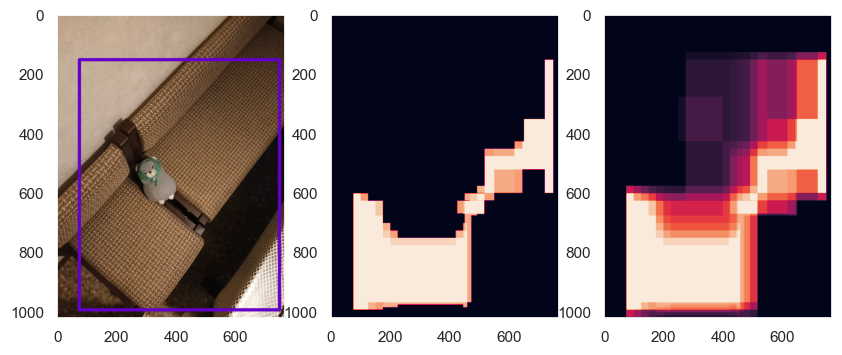

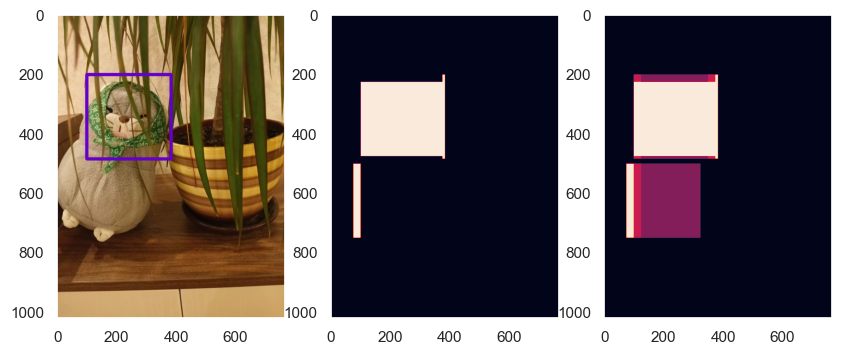

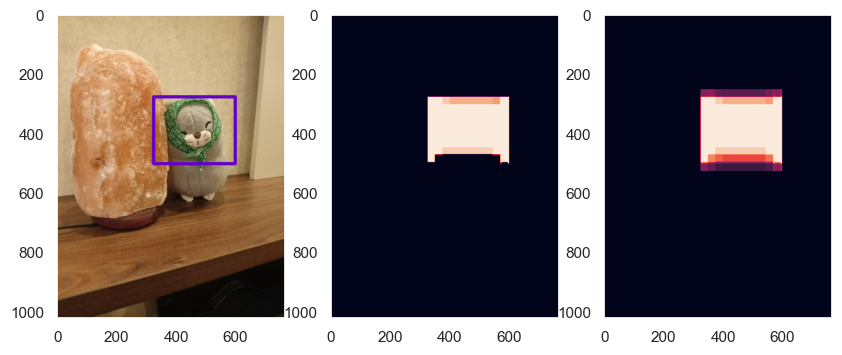

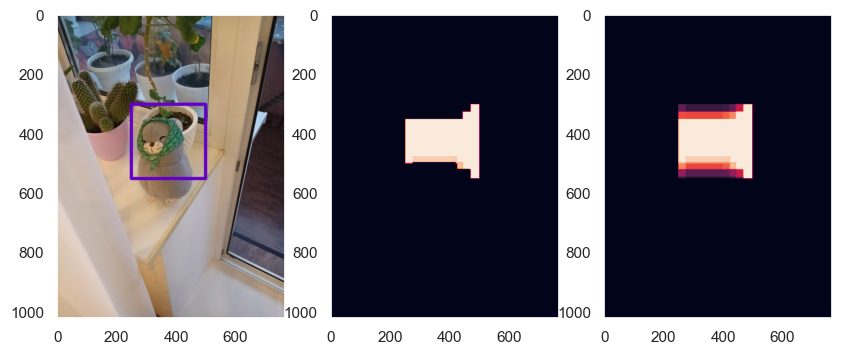

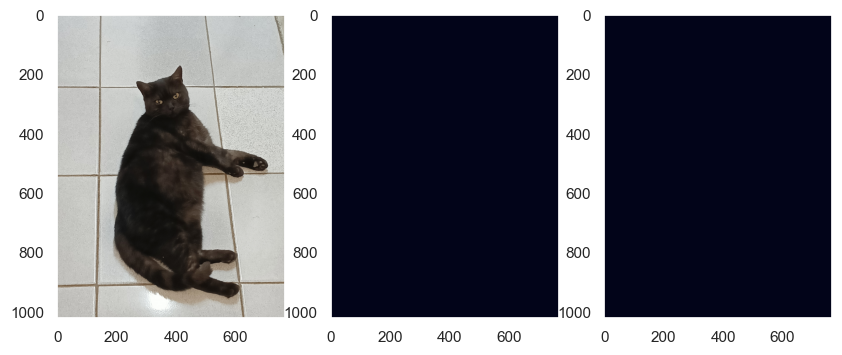

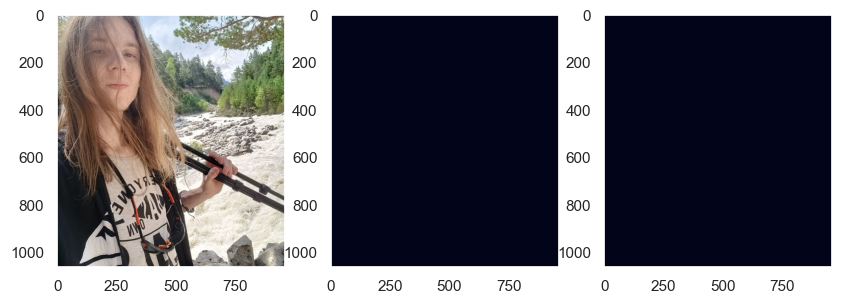

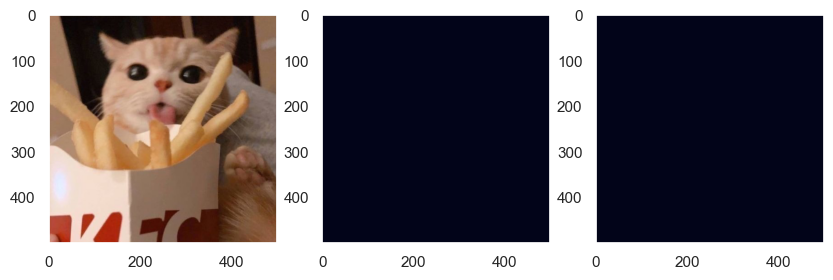

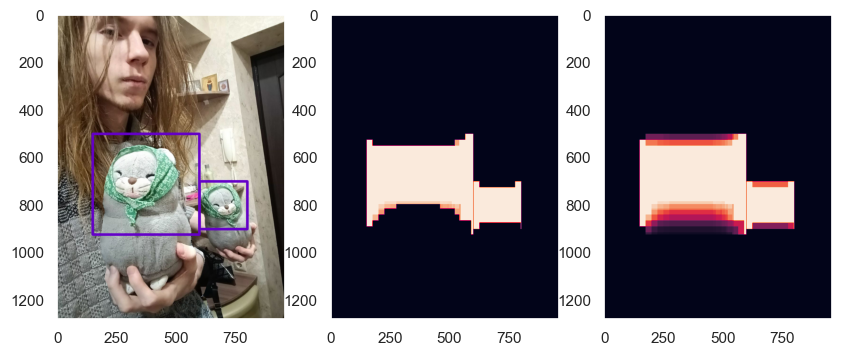

In [25]:
results = detect_tusya(images, visualize=True)